In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import utils
import torchvision
from torchvision import transforms
from pretrained_models import pretrained_models_680
from dataset import BuildDataset, BuildDataLoader
import time
from torchvision.models.detection.image_list import ImageList
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Set paths

pretrained_path = "path to checkpoint680.pth"

imgs_path  = "path to data files"
masks_path= "path to data files"
labels_path= "path to data files"
bboxes_path= "path to data files"

model_path = "path to folder containing trained model"

In [2]:
pretrained_path='/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/checkpoint680.pth'

imgs_path =   '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path =  '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/data/hw3_mycocodata_bboxes_comp_zlib.npy"

# model_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/models0.0007reducedlr/"

model_path = '/content/drive/My Drive/RCNN/'

#Main Class BoxHead

In [3]:
class BoxHead(torch.nn.Module):
    def __init__(self,Classes=3,P=7, device = 'cuda' , evaluate = False):
        super(BoxHead,self).__init__()
        self.C=Classes
        self.P=P
        self.device = device
        self.init_layers()
        self._init_weights()
        self.evaluate = evaluate

    def init_weights(self, l):
        if type(l) == nn.Linear:
          nn.init.normal_(l.weight, mean=0.0, std=0.01)
          if l.bias != None:
            l.bias.data.fill_(0)

    def _init_weights(self):
        ## TODO: initialize the weights
        for l in self.intermediate:
          l.apply(self.init_weights)

        self.classifier.apply(self.init_weights)
        self.regressor.apply(self.init_weights)        
        
        
    def init_layers(self):
        self.intermediate = nn.ModuleList()
        self.intermediate.append(nn.Sequential(torch.nn.Linear(256*self.P*self.P, 1024),torch.nn.ReLU(inplace=False)))
        self.intermediate.append(nn.Sequential(torch.nn.Linear(1024, 1024),torch.nn.ReLU(inplace=False)))
        
        #self.classifier = nn.Sequential(nn.Linear(1024, self.C + 1), nn.Softmax())
        self.classifier = nn.Sequential(nn.Linear(1024, self.C + 1))
        self.regressor =  nn.Sequential(nn.Linear(1024, 4*self.C))
        

    #  This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
    #  Input:
    #       proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #       gt_labels: list:len(bz) {(n_obj)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #  Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
    #       labels: (total_proposals,1) (the class that the proposal is assigned)
    #       regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)
    def create_ground_truth(self,proposals,gt_labels,bbox):
        labels = []
        regressor_target=[]
        
        for i in range(len(proposals)):
            iou= utils.iou(proposals[i],bbox[i])                      #[n_proposals, ground_truth_boxes]
            # iou= iou1(proposals[i],bbox[i])
            max_iou, gt_box_index = torch.max(iou, dim=1)             # n_proposals
            
            l = torch.zeros(proposals[i].shape[0],device = self.device)                    #n_proposals
            l[max_iou>0.5] = gt_labels[i][gt_box_index[max_iou>0.5]]     #n_proposals
            # print(max_iou[max_iou>0.4])
            box    = torch.zeros((proposals[i].shape[0],4))

            gt_box = bbox[i][gt_box_index,:]
            
            box[:,0] = ((gt_box[:,0] + gt_box[:,2])/2 - (proposals[i][:,0]+proposals[i][:,2])/2)/(proposals[i][:,2]-proposals[i][:,0])
            box[:,1] = ((gt_box[:,1] + gt_box[:,3])/2 - (proposals[i][:,1]+proposals[i][:,3])/2)/(proposals[i][:,3]-proposals[i][:,1])
            box[:,2] = torch.log((gt_box[:,2] - gt_box[:,0])/ (proposals[i][:,2] - proposals[i][:,0]))
            box[:,3] = torch.log((gt_box[:,3] - gt_box[:,1])/ (proposals[i][:,3] - proposals[i][:,1]))
            
            labels.append(l)
            regressor_target.append(box)
            
        labels = torch.hstack(labels).reshape(-1,1)                       #dim : (total_proposals,1)
        regressor_target = torch.vstack(regressor_target)                 #dim : (total_prosposals,4)
            
        return labels.to(self.device),regressor_target.to(self.device)



    # This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
    # a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
    # Input:
    #      fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
    #      proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #      P: scalar
    # Output:
    #      feature_vectors: (total_proposals, 256*P*P)  (make sure the ordering of the proposals are the same as the ground truth creation)
    def MultiScaleRoiAlign(self, fpn_feat_list,proposals,P=7):
        #####################################
        # Here you can use torchvision.ops.RoIAlign check the docs
        ####################################
        
        
        fpn_boxes = [[],[],[],[]]           #For each level of feature pyramid
        orig_height= 800 
        orig_width = 1088
        feature_vectors=[]
        for i in range(len(proposals)):
            for j in range(proposals[i].shape[0]):
                x1,y1,x2,y2 = proposals[i][j]
                w = x2-x1
                h = y2-y1
                k = torch.clip(torch.floor(4+torch.log2(torch.sqrt(w*h)/224)),2,5).int()
            
                stride_x = orig_width/fpn_feat_list[k-2].shape[3]
                stride_y = orig_height/fpn_feat_list[k-2].shape[2]

                box = proposals[i][j].reshape(1,-1).clone()
                box[:,0] = box[:,0] / stride_x 
                box[:,2] = box[:,2] / stride_x
                box[:,1] = box[:,1] / stride_y
                box[:,3] = box[:,3] / stride_y
                # import pdb; pdb.set_trace()   
                inp = fpn_feat_list[k-2][i].unsqueeze(0)  # dim: (1,256,H_feat,W_feat)
                op  = torchvision.ops.roi_align(inp, [box], output_size=P, 
                                      spatial_scale=1,
                                      sampling_ratio=-1)  # dim : (1,256,P,P)

                feature_vectors.append(op.view(-1))
                #fpn_boxes[k-2].append(element)
        
        feature_vectors = torch.stack(feature_vectors, dim=0) #dim = (total_proposals, 256*P*P)
        
        '''
        output = [] #Dim len(fpn_list), element: tensor: (K,C,P,P)
        for i, level in enumerate(fpn_boxes):
            level_proposals = torch.stack(level,dim=1)[0][:,1:6]   # dim: (K,5) 
            output.append(torchvision.ops.roi_align(fpn_feat_list[i], level_proposals, output_size=P, 
                                      spatial_scale=orig_height/fpn_feat_list[i].shape[2],
                                      sampling_ratio=4))
            
        '''  
            
        return feature_vectors



    # This function does the post processing for the results of the Box Head for a batch of images
    # Use the proposals to distinguish the outputs from each image
    # Input:
    #       class_logits: (total_proposals,(C+1))
    #       box_regression: (total_proposal,4*C)           ([t_x,t_y,t_w,t_h] format)
    #       proposals: list:len(bz)(per_image_proposals,4) (the proposals are produced from RPN [x1,y1,x2,y2] format)
    #       conf_thresh: scalar
    #       keep_num_preNMS: scalar (number of boxes to keep pre NMS)
    #       keep_num_postNMS: scalar (number of boxes to keep post NMS)
    # Output:
    #       boxes: list:len(bz){(post_NMS_boxes_per_image,4)}  ([x1,y1,x2,y2] format)
    #       scores: list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
    #       labels: list:len(bz){(post_NMS_boxes_per_image)}   (top class of each regressed box)
    def postprocess_detections(self, class_logits, box_regression, proposals, conf_thresh=0.5, keep_num_preNMS=500, keep_num_postNMS=5):
        class_logits = class_logits.cpu()
        box_regression = box_regression.cpu()
      
        class_scores, class_idx = torch.max(class_logits, dim =1)

        background = class_idx==0
        class_scores[background] = 0

        class_idx_cp = class_idx.clone() - 1
        class_idx_cp[class_idx == 0] = 0

        # print("class scores", class_scores)
        # print("class scores", class_idx)

        cols_to_idx           =     np.linspace(4*class_idx_cp,4*class_idx_cp+3,4).T
        rows                  =     np.arange(box_regression.shape[0]).reshape(-1,1)

        boxes_regr        = box_regression[rows, cols_to_idx]

        boxes  = []
        scores = []
        labels = []
        iou_thresh = 0.65

        j=0
        for i in range(len(proposals)):
          proposals_per_image = proposals[i].shape[0]
          unsorted_boxes_coded = boxes_regr[j:j+proposals_per_image]
          unsorted_boxes = utils.output_decodingd(unsorted_boxes_coded,proposals[i].cpu(), device='cpu')
          
          unsorted_scores = class_scores[j:j+proposals_per_image]
          unsorted_labels = class_idx[j:j+proposals_per_image]

          #Removing out of bound boxes
          out_of_range = torch.logical_or(unsorted_boxes[:,0]<0 , unsorted_boxes[:,1]<0)
          out_of_range = torch.logical_or(out_of_range,torch.logical_or(unsorted_boxes[:,2]>1088, unsorted_boxes[:,3]>800))
          unsorted_scores[out_of_range] = 0

          sorted_scores, sorted_score_idx = torch.sort(unsorted_scores, descending = True)
          
          idx = sorted_scores>conf_thresh
          sorted_scores = sorted_scores[idx]
          sorted_score_idx = sorted_score_idx[idx]

          if (sorted_scores.shape[0]>keep_num_preNMS):
              sorted_scores = sorted_scores[:keep_num_preNMS]
              sorted_score_idx = sorted_score_idx[:keep_num_preNMS]
          
          pre_nms_scores = sorted_scores
          pre_nms_boxes = unsorted_boxes[sorted_score_idx]
          pre_nms_labels = unsorted_labels[sorted_score_idx]

          ious = utils.iou(pre_nms_boxes.to(self.device), pre_nms_boxes.to(self.device)).triu(diagonal = 1)
          
          #print("ious", ious)
          #print("ious shape", ious.shape)

          post_nms_idx    = (ious>iou_thresh).sum(dim=0) == 0
          #print("nms", post_nms_idx)
          post_nms_scores = pre_nms_scores[post_nms_idx]
          post_nms_boxes  = pre_nms_boxes[post_nms_idx]
          post_nms_labels = pre_nms_labels[post_nms_idx]

          if (post_nms_scores.shape[0]>keep_num_postNMS):
              boxes.append(post_nms_boxes[:keep_num_postNMS])
              scores.append(post_nms_scores[:keep_num_postNMS])
              labels.append(post_nms_labels[:keep_num_postNMS])
          else:
              boxes.append(post_nms_boxes)
              scores.append(post_nms_scores)
              labels.append(post_nms_labels)

          j= j+proposals_per_image

        # print("Len boxes", len(boxes))
        # print("Len Scores", len(scores))
        # print("Len Labels", len(labels))

        return boxes, scores, labels




    # Compute the total loss of the classifier and the regressor
    # Input:
    #      class_logits: (total_proposals,(C+1)) (as outputed from forward, not passed from softmax so we can use CrossEntropyLoss)
    #      box_preds: (total_proposals,4*C)      (as outputed from forward)
    #      labels: (total_proposals,1)
    #      regression_targets: (total_proposals,4)
    #      l: scalar (weighting of the two losses)
    #      effective_batch: scalar
    # Outpus:
    #      loss: scalar
    #      loss_class: scalar
    #      loss_regr: scalar
    def compute_loss(self,class_logits, box_preds, labels, regression_targets,l=10,effective_batch=150):
        

        M = effective_batch
        n_neg = (labels[:,0] == 0).sum().item()
        n_pos = labels.shape[0] - n_neg
        #print("Neg:",n_neg)
        #print("pos:",n_pos)
        if n_pos < (3*M/4):
          num_neg_sample       = M - n_pos
          neg_idx              = np.random.choice(n_neg, num_neg_sample, replace = False)
          pos_idx              = torch.arange(n_pos)
          
        else:
          pos_idx              = np.random.choice(n_pos, (3*M)//4, replace = False)
          neg_idx              = np.random.choice(n_neg, M - ((3*M)//4), replace = False)

        p_class_pred           =     class_logits[(labels[:,0] != 0) , :][pos_idx,:]
        n_class_pred           =     class_logits[(labels[:,0] == 0) , :][neg_idx,:]
        p_label                =     labels[ (labels[:,0] != 0) ,:][pos_idx,:]
        n_label                =     labels[ (labels[:,0] == 0) ,:][neg_idx,:]

        class_pred             =     torch.vstack((p_class_pred,n_class_pred))
        class_gt               =     torch.vstack((p_label,n_label))

        loss_cp              =     nn.CrossEntropyLoss()
        #loss_cp              =     nn.NLLLoss()
        #loss_class           =     loss_cp(torch.log(class_pred), class_gt[:,0])
        loss_class           =     loss_cp(class_pred, class_gt[:,0])
        
        p_box_pred           =     box_preds[(labels[:,0] != 0) , :][pos_idx,:]          #(no of +ve samples , 4*C)

        p_labels_to_idx      =     (p_label - 1)*4
        if p_labels_to_idx.is_cuda:
          p_labels_to_idx = p_labels_to_idx.cpu().numpy()

        col_to_idx           =     np.linspace(p_labels_to_idx,p_labels_to_idx+3,4).T
        rows                 =     np.arange(p_box_pred.shape[0]).reshape(-1,1)

        box_pred             =     p_box_pred[rows,col_to_idx]
        box_gt               =     regression_targets[(labels[:,0] != 0) , :][pos_idx,:]

        #print("box_pred", box_pred)
        #print("box_gt", box_gt)

        L1_loss              =     torch.nn.SmoothL1Loss(reduction = 'sum')
        loss_regr            =     L1_loss(box_pred.squeeze(0),box_gt) 

        loss = loss_class + l*loss_regr 
        
        
        return loss, loss_class, l*loss_regr



    # Forward the pooled feature vectors through the intermediate layer and the classifier, regressor of the box head
    # Input:
    #        feature_vectors: (total_proposals, 256*P*P)
    # Outputs:
    #        class_logits: (total_proposals,(C+1)) (we assume classes are C classes plus background, notice if you want to use
    #                                               CrossEntropyLoss you should not pass the output through softmax here)
    #        box_pred:     (total_proposals,4*C)
    def forward(self, feature_vectors):
        out = feature_vectors
        for l in self.intermediate: 
            out = l(out)
        
        class_logits = self.classifier(out)
        box_pred     = self.regressor(out) 

        if self.evaluate:
          softmax = torch.nn.Softmax(dim = 1)
          class_logits = softmax(class_logits)
            
        return class_logits, box_pred

# Loading data

In [4]:
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 2
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

# Training Model

In [9]:
if __name__ == '__main__':
    # Put the path were you save the given pretrained model
    # pretrained_path='/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/checkpoint680.pth'
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
      backbone, rpn = pretrained_models_680(pretrained_path)
    
    boxHead = BoxHead(device=device)
    boxHead.to(device)
    # we will need the ImageList from torchvision
    from torchvision.models.detection.image_list import ImageList

    # imgs_path =   '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/data/hw3_mycocodata_img_comp_zlib.h5'
    # masks_path =  '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/data/hw3_mycocodata_mask_comp_zlib.h5'
    # labels_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/data/hw3_mycocodata_labels_comp_zlib.npy"
    # bboxes_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/data/hw3_mycocodata_bboxes_comp_zlib.npy"

    # Here we keep the top 20, but during training you should keep around 200 boxes from the 1000 proposals
    keep_topK= 200

    lr = 0.0007
    optimizer = torch.optim.Adam(boxHead.parameters(), lr=lr)
    num_epochs= 40
    epoch = -1
    
    resume = False
    # model_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/models/"

    loss_ = []
    loss_class_ = []
    loss_regr_  = []

    if resume == True:
      epoch_to_load = 'epoch' +str(epoch)
      path = model_path + str(epoch_to_load)
      checkpoint = torch.load(path)
      boxHead.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      epoch = checkpoint['epoch']
      loss_ = checkpoint['loss']
      loss_class_ = checkpoint['loss_class']
      loss_class_ = checkpoint['loss_regr']
    ground_dict = {}

    for epochs in range(epoch+1, num_epochs):
        if epochs == 7 or epochs == 12:
            for g in optimizer.param_groups:
              g['lr'] = g['lr']/10
        start = time.time()
        for iter, batch in enumerate(train_loader, 0):
            images = batch['images'].to(device)
            gt_label = batch['labels']
            bbox = batch['bbox']

            #with torch.no_grad():
            backout = backbone(images)
            # The RPN implementation takes as first argument the following image list
            im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
            # Then we pass the image list and the backbone output through the rpn
            rpnout = rpn(im_lis, backout)

            #The final output is
            # A list of proposal tensors: list:len(bz){(keep_topK,4)}
            proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
            # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
            fpn_feat_list= list(backout.values())
          
            #Generating feature vectors 
            # import pdb;pdb.set_trace()
            feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
            labels, regressor_target = boxHead.create_ground_truth(proposals, gt_label, bbox)
            
            class_logits, box_pred   = boxHead.forward(feature_vectors)
            loss, loss_class, loss_regr = boxHead.compute_loss(class_logits, box_pred, labels.long(), regressor_target, effective_batch=32)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_.append(loss)
            loss_class_.append(loss_class)
            loss_regr_.append(loss_regr)
            if (iter+1)%10 == 0:
                print("epoch: %d , loss: %f, Regression Loss: %f, Classification Loss: %f" %(epochs, loss, loss_regr, loss_class))  
    
        if (epochs%1==0):
            print("loss: %d, Regression Loss: %f, Classification Loss: %f" %(loss, loss_class, loss_regr))
            print("Time per Epoch: ",  time.time()-start)
            print("Epoch %d/%d" %(epochs+1, num_epochs))
            torch.save({
              'epoch': epochs,
              'model_state_dict': boxHead.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss' : loss_,
              'loss_class' : loss_class_,
              'loss_regr'  : loss_regr_ 
              }, model_path+"epoch"+str(epochs))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


epoch: 8 , loss: 21.087542, Regression Loss: 19.682184, Classification Loss: 1.405357
epoch: 8 , loss: 16.239170, Regression Loss: 14.851308, Classification Loss: 1.387863


KeyboardInterrupt: ignored

# Load model to plot results

Note: In line 18 below, chenge "epoch_to_load" to the name of saved model file

In [5]:
keep_topK=200

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
with torch.no_grad():
  backbone, rpn = pretrained_models_680(pretrained_path)

boxHead = BoxHead(device=device, evaluate = True)
boxHead.to(device)

lr = 0.0007
optimizer = torch.optim.Adam(boxHead.parameters(), lr=lr)

resume = True
# model_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/models/"

if resume == True:
  # epoch_to_load = 'epoch40'
  epoch_to_load = 'epoch_lr_final_0.000719'
  path = model_path + str(epoch_to_load)
  checkpoint = torch.load(path)
  boxHead.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']

# 7.1

Note: The plots are generated one per class. For every image there are three plots. Each plot corresponds to a particular class and the bounding box appears only in the appropriate class plot.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


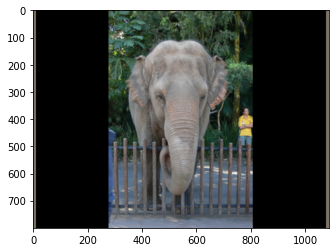

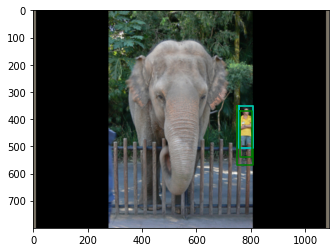

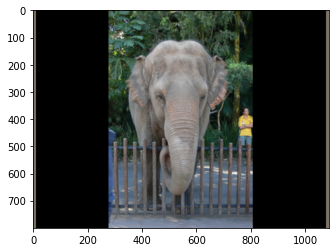

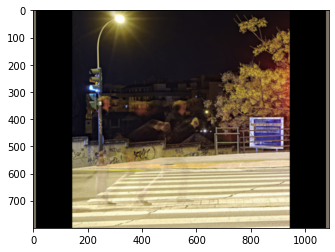

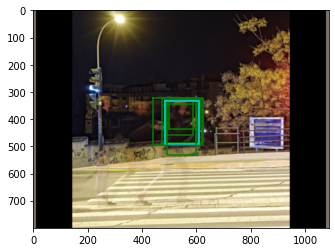

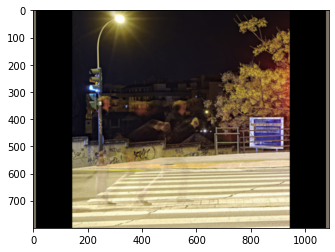

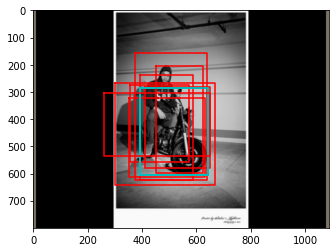

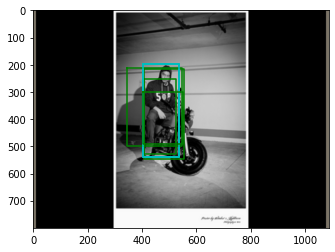

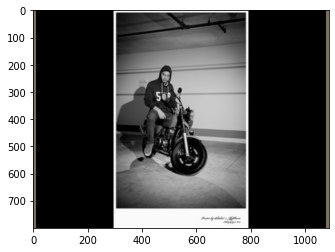

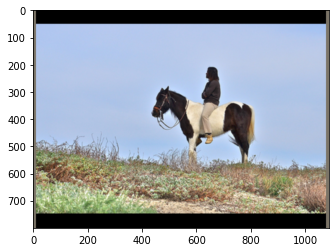

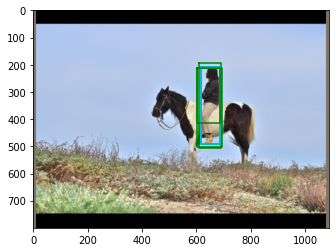

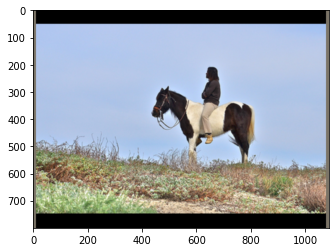

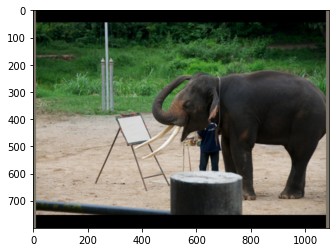

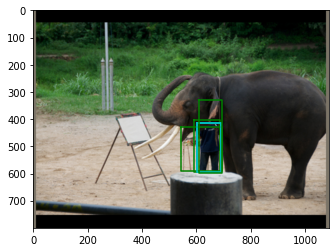

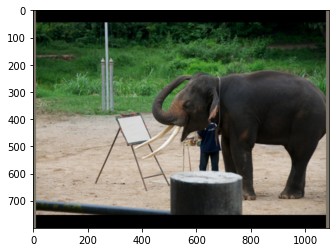

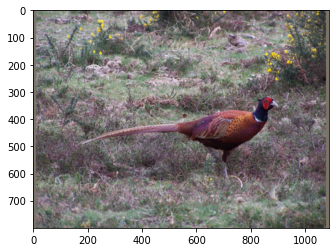

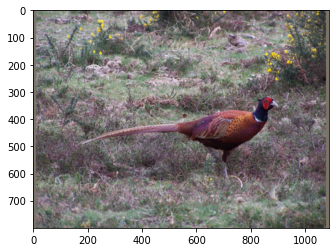

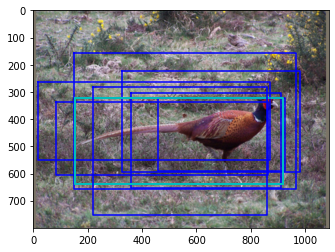

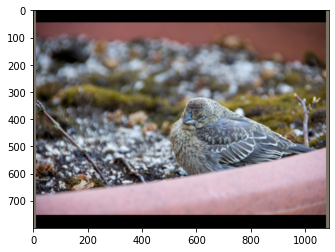

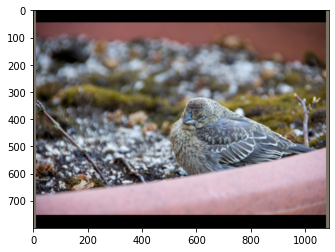

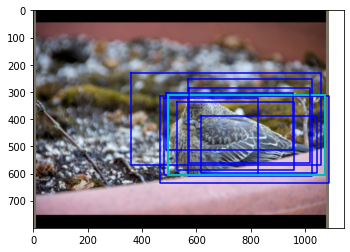

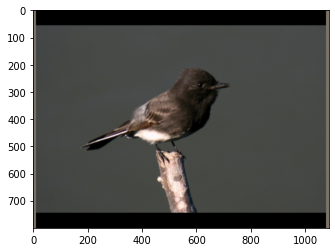

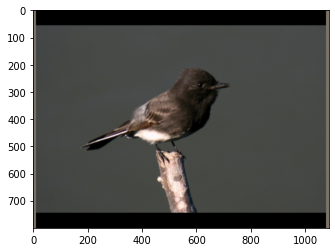

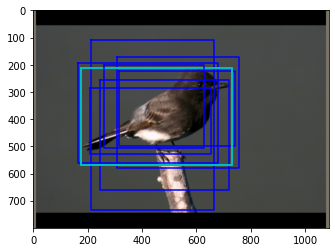

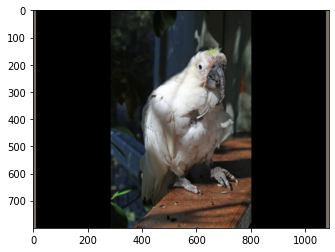

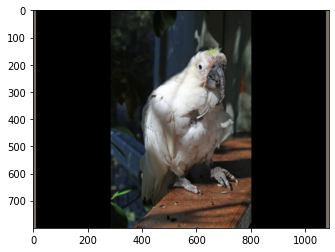

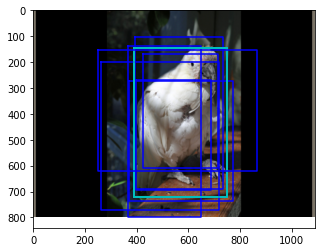

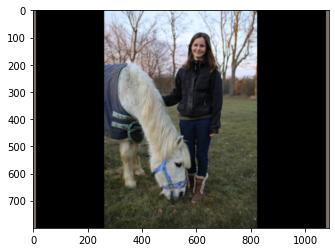

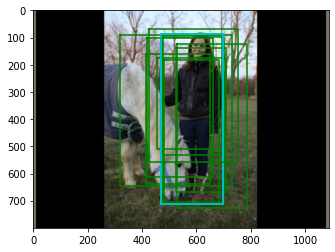

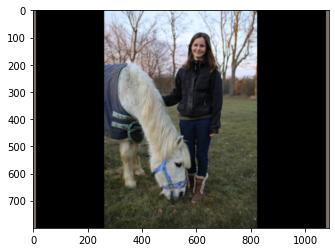

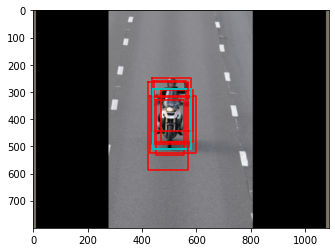

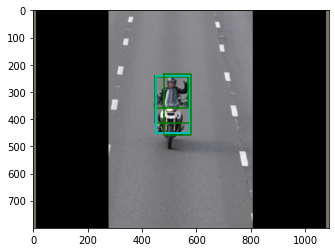

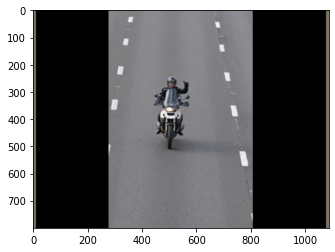

In [6]:
# Color Scheme : Green -> Person --> 2
#                Blue -> Animal  --> 3
#                Red -> Vehicle  --> 1
start = time.time()
keep_topK = 20
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                              std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                              std = [ 1., 1., 1. ]),
                        ])

# save_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/7.1/"
ind = 0


for iter, batch in enumerate(test_loader, 0):
    images = batch['images']
    gt_label = batch['labels']
    bbox = batch['bbox']

    #with torch.no_grad():
    backout = backbone(images)
    # The RPN implementation takes as first argument the following image list
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    # Then we pass the image list and the backbone output through the rpn
    rpnout = rpn(im_lis, backout)


    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]

    #Generating feature vectors 
    labels, regressor_target = boxHead.create_ground_truth(proposals, gt_label, bbox)

    prop = proposals[0]

    wp = prop[:,2] - prop[:,0]
    hp = prop[:,3] - prop[:,1]
    xp = (prop[:,0] + prop[:,2])/2
    yp = (prop[:,1] + prop[:,3])/2
    
    gt_box= torch.zeros(regressor_target[:20,:].shape)
    gt_box[:,0] = regressor_target[:20,0]*wp + xp - torch.exp(regressor_target[:20,2])*wp/2
    gt_box[:,1] = regressor_target[:20,1]*hp + yp - torch.exp(regressor_target[:20,3])*hp/2
    gt_box[:,2] = regressor_target[:20,0]*wp + xp + torch.exp(regressor_target[:20,2])*wp/2 
    gt_box[:,3] = regressor_target[:20,1]*hp + yp + torch.exp(regressor_target[:20,3])*hp/2

    images = invTrans(images)
    plt.figure(1)
    plt.imshow(images[0,:,:,:].cpu().numpy().transpose(1,2,0))
    
    for i in range(prop.shape[0]):
      if labels[i] == 1:
        coord = gt_box[i,:]
        plt.plot([coord[0], coord[2], coord[2], coord[0], coord[0]], [coord[1], coord[1], coord[3], coord[3], coord[1]], 'c-')
        coord = prop[i,:]
        plt.plot([coord[0], coord[2], coord[2], coord[0], coord[0]], [coord[1], coord[1], coord[3], coord[3], coord[1]], 'r-')
    # plt.savefig(save_path + str(ind) + 'vehicle')

    plt.show()

    plt.figure(2)
    plt.imshow(images[0,:,:,:].cpu().numpy().transpose(1,2,0))
    for i in range(prop.shape[0]):
      if labels[i] == 2:
        coord = gt_box[i,:]
        plt.plot([coord[0], coord[2], coord[2], coord[0], coord[0]], [coord[1], coord[1], coord[3], coord[3], coord[1]], 'c-')
        coord = prop[i,:]
        plt.plot([coord[0], coord[2], coord[2], coord[0], coord[0]], [coord[1], coord[1], coord[3], coord[3], coord[1]], 'g-')
    # plt.savefig(save_path + str(ind) + 'person')
    plt.show()
    
    plt.figure(3)
    plt.imshow(images[0,:,:,:].cpu().numpy().transpose(1,2,0))
    for i in range(prop.shape[0]):
      if labels[i] == 3:
        coord = gt_box[i,:]
        plt.plot([coord[0], coord[2], coord[2], coord[0], coord[0]], [coord[1], coord[1], coord[3], coord[3], coord[1]], 'c-')
        coord = prop[i,:]
        plt.plot([coord[0], coord[2], coord[2], coord[0], coord[0]], [coord[1], coord[1], coord[3], coord[3], coord[1]], 'b-')
    # plt.savefig(save_path + str(ind) + 'animal')
    ind +=1
    plt.show()
    if(iter == 10):
      break    

# 7.2 : Losses


In [7]:
loss_list = []
loss_c_list = []
loss_r_list = []

checkpoint = torch.load(path)
loss = checkpoint['loss']
loss_c=checkpoint['loss_class']
loss_r= checkpoint['loss_regr']

In [8]:
print(len(loss))

t = 26120
s = 1306 

loss_list = [sum(loss[i:i+s])/s for i in range(0,t,s)] 
loss_c_list = [sum(loss_c[i:i+s])/s for i in range(0,t,s)] 
loss_r_list = [sum(loss_r[i:i+s])/s for i in range(0,t,s)] 

# plt.plot(loss)
# plt.show()

26120


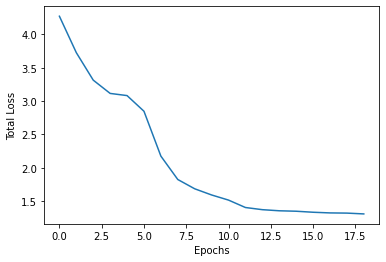

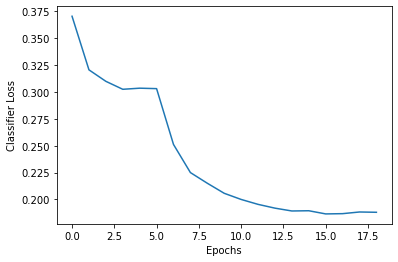

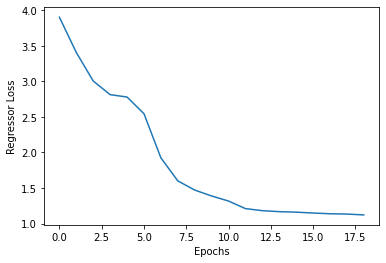

In [9]:
# save_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/7.2/"
plt.figure(0)
plt.plot(loss_list[1:])
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
# plt.savefig(save_path + 'total loss.png')
plt.show()

plt.figure(1)
plt.plot(loss_c_list[1:])
plt.xlabel('Epochs')
plt.ylabel('Classifier Loss')
# plt.savefig(save_path + 'loss_c.png')
plt.show()

plt.figure(2)
plt.plot(loss_r_list[1:])
plt.xlabel('Epochs')
plt.ylabel('Regressor Loss')
# plt.savefig(save_path + 'loss_r.png')
plt.show()


##Validation curves  
Note: In line 17 below change path to saved models path

In [ ]:
losst_ = []
losst_c_ = []
losst_r_ = []

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path)
boxHead = BoxHead(device=device, evaluate = False)
boxHead.to(device)

backbone.eval()
rpn.eval()

s = 0

total_epochs = 20
for i in range(total_epochs):
  path = model_path+'epoch_lr_final_0.0007'+str(i)
  checkpoint = torch.load(path)
  boxHead.load_state_dict(checkpoint['model_state_dict'])
  boxHead.eval()

  with torch.no_grad():
      for iter, batch in enumerate(test_loader,0):
        print("Epoch: " + str(i) + "Iteration: " + str(iter))
        images = batch['images']
        gt_label = batch['labels']
        bbox = batch['bbox']
        backout = backbone(images)
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list= list(backout.values())
        feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
        labels, regressor_target = boxHead.create_ground_truth(proposals, gt_label, bbox)        
        class_logits, box_pred   = boxHead.forward(feature_vectors)
        loss, loss_c, loss_r = boxHead.compute_loss(class_logits, box_pred, labels.long(), regressor_target, effective_batch=32)

        losst_.append(loss.item())
        losst_c_.append(loss_c.item())
        losst_r_.append(loss_r.item())

  if i==0 :
    print(len(losst_))
    s= len(losst_)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Streaming output truncated to the last 5000 lines.
Epoch: 4Iteration: 232
Epoch: 4Iteration: 233
Epoch: 4Iteration: 234
Epoch: 4Iteration: 235
Epoch: 4Iteration: 236
Epoch: 4Iteration: 237
Epoch: 4Iteration: 238
Epoch: 4Iteration: 239
Epoch: 4Iteration: 240
Epoch: 4Iteration: 241
Epoch: 4Iteration: 242
Epoch: 4Iteration: 243
Epoch: 4Iteration: 244
Epoch: 4Iteration: 245
Epoch: 4Iteration: 246
Epoch: 4Iteration: 247
Epoch: 4Iteration: 248
Epoch: 4Iteration: 249
Epoch: 4Iteration: 250
Epoch: 4Iteration: 251
Epoch: 4Iteration: 252
Epoch: 4Iteration: 253
Epoch: 4Iteration: 254
Epoch: 4Iteration: 255
Epoch: 4Iteration: 256
Epoch: 4Iteration: 257
Epoch: 4Iteration: 258
Epoch: 4Iteration: 259
Epoch: 4Iteration: 260
Epoch: 4Iteration: 261
Epoch: 4Iteration: 262
Epoch: 4Iteration: 263
Epoch: 4Iteration: 264
Epoch: 4Iteration: 265
Epoch: 4Iteration: 266
Epoch: 4Iteration: 267
Epoch: 4Iteration: 268
Epoch: 4Iteration: 269
Epoch: 4Iteration: 270
Epoch: 4Iteration: 271
Epoch: 4Iteration: 272
Epoch:

In [ ]:

t = len(losst_)

loss_list = [sum(losst_[i:i+s])/s for i in range(0,t,s)] 
loss_c_list = [sum(losst_c_[i:i+s])/s for i in range(0,t,s)] 
loss_r_list = [sum(losst_r_[i:i+s])/s for i in range(0,t,s)] 

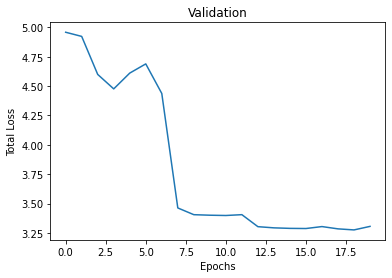

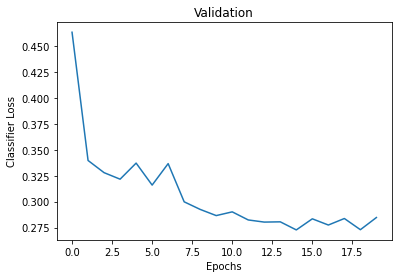

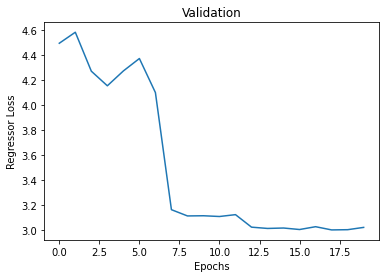

In [ ]:
save_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/7.2/"
plt.figure(0)
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title("Validation")
plt.savefig(save_path + 'vtotal loss.png')
plt.figure(1)
plt.plot(loss_c_list)
plt.xlabel('Epochs')
plt.ylabel('Classifier Loss')
plt.title("Validation")
plt.savefig(save_path + 'vloss_c.png')
plt.figure(2)
plt.plot(loss_r_list)
plt.xlabel('Epochs')
plt.ylabel('Regressor Loss')
plt.title("Validation")
plt.savefig(save_path + 'vloss_r.png')


#7.3

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


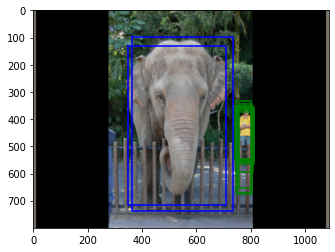

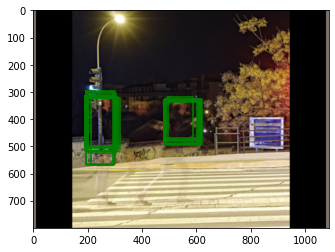

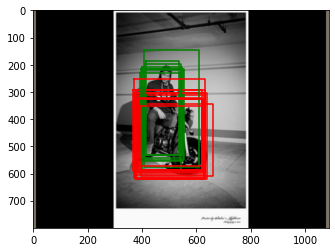

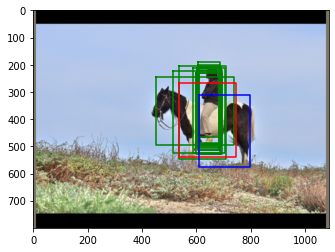

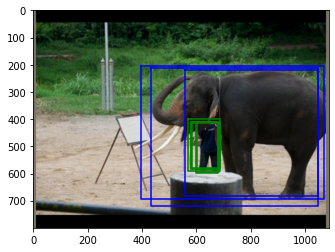

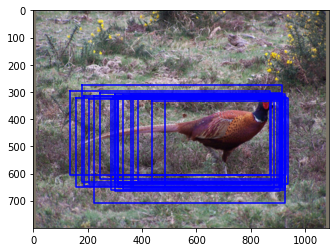

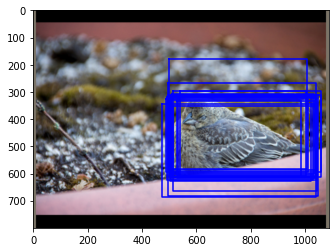

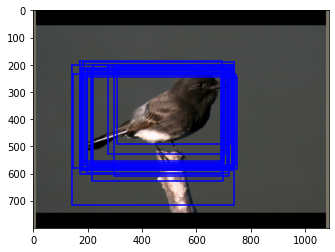

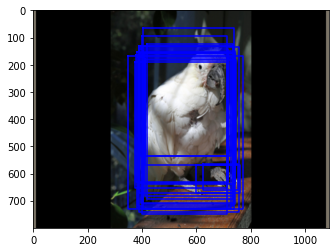

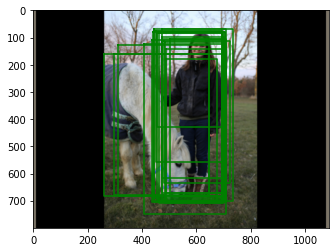

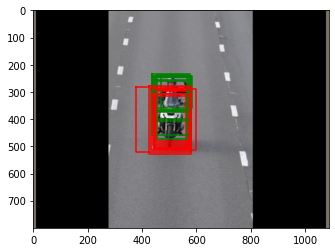

In [10]:
# Color Scheme : Green -> Person --> 2
#                Blue -> Animal  --> 3
#                Red -> Vehicle  --> 1
boxHead.evaluate = True
boxHead.eval()
backbone.eval()
rpn.eval()
start = time.time()
keep_topK = 200
keep_num_preNMS = 20
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                              std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                              std = [ 1., 1., 1. ]),
                        ])

# save_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/7.3/"
ind = 0
conf_thresh = 0.5
for iter, batch in enumerate(test_loader, 0):
    images = batch['images']
    gt_label = batch['labels']
    bbox = batch['bbox']

    #with torch.no_grad():
    backout = backbone(images)
    # The RPN implementation takes as first argument the following image list
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    # Then we pass the image list and the backbone output through the rpn
    rpnout = rpn(im_lis, backout)

    #The final output is
    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    fpn_feat_list= list(backout.values())
  
    #Generating feature vectors 
    # import pdb;pdb.set_trace()
    feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
    labels, regressor_target = boxHead.create_ground_truth(proposals, gt_label, bbox)
    
    class_logits, box_pred   = boxHead.forward(feature_vectors)

    class_logits = class_logits.cpu()
    box_regression = box_pred.cpu()
  
    class_scores, class_idx = torch.max(class_logits, dim =1)

    background = class_idx==0
    class_scores[background] = 0

    class_idx_cp = class_idx.clone() - 1
    class_idx_cp[class_idx == 0] = 0

    cols_to_idx           =     np.linspace(4*class_idx_cp,4*class_idx_cp+3,4).T
    rows                  =     np.arange(box_regression.shape[0]).reshape(-1,1)

    boxes_regr        = box_regression[rows, cols_to_idx]

    boxes  = []
    scores = []
    labels = []
    iou_thresh = 0.65

    j=0
    for i in range(len(proposals)):
      proposals_per_image = proposals[i].shape[0]
      unsorted_boxes_coded = boxes_regr[j:j+proposals_per_image]
      unsorted_boxes = utils.output_decodingd(unsorted_boxes_coded,proposals[i].cpu(), device='cpu')
      
      unsorted_scores = class_scores[j:j+proposals_per_image]
      unsorted_labels = class_idx[j:j+proposals_per_image]

      #Removing out of bound boxes
      out_of_range = torch.logical_or(unsorted_boxes[:,0]<0 , unsorted_boxes[:,1]<0)
      out_of_range = torch.logical_or(out_of_range,torch.logical_or(unsorted_boxes[:,2]>1088, unsorted_boxes[:,3]>800))
      unsorted_scores[out_of_range] = 0

      sorted_scores, sorted_score_idx = torch.sort(unsorted_scores, descending = True)
      
      idx = sorted_scores>conf_thresh
      sorted_scores = sorted_scores[idx]
      sorted_score_idx = sorted_score_idx[idx]

      if (sorted_scores.shape[0]>keep_num_preNMS):
          sorted_scores = sorted_scores[:keep_num_preNMS]
          sorted_score_idx = sorted_score_idx[:keep_num_preNMS]
      
      pre_nms_scores = sorted_scores
      pre_nms_boxes = unsorted_boxes[sorted_score_idx]
      pre_nms_labels = unsorted_labels[sorted_score_idx]
      
      scores.append(pre_nms_scores)
      boxes.append(pre_nms_boxes)
      labels.append(pre_nms_labels)

    images = invTrans(images)
    
    plt.figure(1)
    plt.imshow(images[0,:,:,:].cpu().numpy().transpose(1,2,0))
    
    scores_0 = scores[0]
    boxes_0 = boxes[0]
    labels_0 = labels[0]

    for i in range(scores_0.shape[0]):
      if labels_0[i] == 1:
        color = 'r-'
      elif labels_0[i] == 2:
        color = 'g-'
      elif labels_0[i] == 3:
        color = 'b-'
      coord = boxes_0[i,:]
      plt.plot([coord[0], coord[2], coord[2], coord[0], coord[0]], [coord[1], coord[1], coord[3], coord[3], coord[1]], color)
    # plt.savefig(save_path + str(ind))
    plt.show()
    ind +=1
    if iter == 10:
      break    

#7.4





In [ ]:
# input:
#       scores:      list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
#       labels:      list:len(bz){(post_NMS_boxes_per_image)}   (top class of each regressed box)
#       boxes:       list:len(bz){(post_NMS_boxes_per_image,4)}  ([x1,y1,x2,y2] format)
#       gt_label:    list:len(bz){(n_obj)}
#       bbox:        list:len(bz){(n_obj, 4)}
def RCNN_evaluation(NMS_scores, NMS_labels, NMS_boxes, true_label, true_bbox ):
  match = {}
  scores = {}
  trues = {}

  match[1] = []
  match[2] = []
  match[3] = []

  scores[1] = []
  scores[2] = []
  scores[3] = []

  trues[1] = 0
  trues[2] = 0
  trues[3] = 0

  batch_size = len(gt_label)
  IoU_thresh = 0.65
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # import pdb; pdb.set_trace()
  for i in range(batch_size):
    pred_scores = NMS_scores[i].to(device)
    pred_labels = NMS_labels[i].to(device)
    pred_boxes  = NMS_boxes[i].to(device)

    gt_labels = true_label[i].to(device)
    gt_box    = true_bbox[i].to(device)

    trues[1] += (gt_labels == 1).sum().item()
    trues[2] += (gt_labels == 2).sum().item()
    trues[3] += (gt_labels == 3).sum().item()

    if pred_scores.shape[0] == 0:
      for h in range(gt_labels.shape[0]):
        flag = gt_labels[h].int().item() 
        match[flag] += [0]
        scores[flag] += [0]
      continue

    #Calculat IOU of every gt_box with every pred box
    IoU = utils.iou(gt_box, pred_boxes)

    #For every ground truth mask find the corresponding predicted mask with maximum IoU
    match_box_iou, match_box_idx                =   torch.max(IoU, dim = 1)
    match_class                             =   pred_labels[match_box_idx]
    match_scores                            =   pred_scores[match_box_idx]
    
    for j in range(gt_labels.shape[0]):
      if match_box_iou[j] > IoU_thresh and match_class[j] == gt_labels[j]:
        flag = gt_labels[j].int().item()
        match[flag] += [1]
        scores[flag] += [match_scores[j].item()]
      else:
        flag = gt_labels[j].int().item()
        match[flag] += [0]
        scores[flag] += [match_scores[j].item()]

    non_match_flag = torch.ones(pred_labels.shape[0], dtype = torch.bool)
    non_match_flag[match_box_idx] = False
    
    if non_match_flag.sum() != 0:
      non_match_class      = pred_labels[non_match_flag]
      non_match_scores     = pred_scores[non_match_flag]

      for p in range(non_match_class.shape[0]):
        flag = non_match_class[p].int().item()
        match[flag] += [0]
        scores[flag] += [non_match_scores[p].item()]
    else:
      continue

  return match, scores, trues    
  

In [ ]:
match_values = {}
score_values = {}
total_trues = {}

match_values[1] = []
match_values[2] = []
match_values[3] = []

score_values[1] = []
score_values[2] = []
score_values[3] = []

total_trues[1] = 0
total_trues[2] = 0
total_trues[3] = 0


AP_dict = {}
AP_dict[1] = []
AP_dict[2] = []
AP_dict[3] = []

# Test_loader has to be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
boxHead.evaluate = True
boxHead.eval()
backbone.eval()
rpn.eval()

for iter, batch in enumerate(test_loader, 0):
  print(iter)
  images = batch['images']
  gt_label = batch['labels']
  bbox = batch['bbox']

  backout = backbone(images)
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  rpnout = rpn(im_lis, backout)
  proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
  fpn_feat_list= list(backout.values())
  feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
  labels, regressor_target = boxHead.create_ground_truth(proposals, gt_label, bbox)
  
  class_logits, box_pred   = boxHead.forward(feature_vectors)
  boxes, scores, labels = boxHead.postprocess_detections(class_logits, box_pred, proposals, keep_num_postNMS=3)

  match, scores, trues = RCNN_evaluation(scores, labels, boxes, gt_label, bbox)
  print('match: ', match)
  print('scores: ', scores )
  print('total_trues: ', trues)

  match_values[1] += match[1]
  match_values[2] += match[2]
  match_values[3] += match[3]

  score_values[1] += scores[1]
  score_values[2] += scores[2]
  score_values[3] += scores[3]

  total_trues[1] += trues[1]
  total_trues[2] += trues[2]
  total_trues[3] += trues[3]

  del backout, im_lis, rpnout, proposals, fpn_feat_list, feature_vectors, regressor_target, class_logits, box_pred, boxes, scores, labels
  torch.cuda.empty_cache()




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0
match:  {1: [], 2: [0, 0], 3: [0, 1, 0]}
scores:  {1: [], 2: [0.997485876083374, 0.9810990691184998], 3: [0.7538871765136719, 0.9946022629737854, 0.7716853022575378]}
total_trues:  {1: 0, 2: 1, 3: 1}
1
match:  {1: [], 2: [1, 0, 0], 3: [1]}
scores:  {1: [], 2: [0.9819746613502502, 0.9856033325195312, 0.5070012807846069], 3: [0.9950927495956421]}
total_trues:  {1: 0, 2: 1, 3: 1}
2
match:  {1: [1, 0, 0], 2: [1, 0], 3: [1]}
scores:  {1: [0.9998223185539246, 0.952549397945404, 0.8275763988494873], 2: [0.9915302991867065, 0.9176918864250183], 3: [0.9921594858169556]}
total_trues:  {1: 1, 2: 1, 3: 1}
3
match:  {1: [1, 0], 2: [1, 0, 0, 1], 3: []}
scores:  {1: [0.9895046949386597, 0.9865309596061707], 2: [0.9977847933769226, 0.7893978953361511, 0.7457370162010193, 0.9997385144233704], 3: []}
total_trues:  {1: 1, 2: 2, 3: 0}
4
match:  {1: [], 2: [1], 3: [0, 0, 0, 0]}
scores:  {1: [], 2: [0.9783397912979126], 3: [0.8033699989318848, 0.9813093543052673, 0.9889854192733765, 0.8020540475845337]}
t

{1: 0.7057303157899217, 2: 0.7584747532272993, 3: 0.823301761807551}


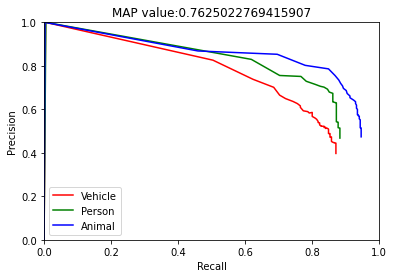

In [ ]:
# save_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/7.4/"
area = 0
AP = {}
for j in range(1,4):
  if len(match_values[j]) > 0:
    # maximum_score = score_values[j].max()
    maximum_score = max(score_values[j])
    ln= np.linspace(0.6,maximum_score,num=100)
    precision_mat= np.zeros(101)
    recall_mat= np.zeros(101)
    for i ,th in enumerate(ln):
      # th = 0.2
      # match_values[j]         = [ 1   0  1   0  0 0 0 0  1  1  1  1]
      # score_values[j]         = [.5  .5 .3  .9  0 0 0 0 .1 .2 .8 .3]
      # score_values[j] > th    = [ T   T  T   T  F F F F  F  F  T  T]
      # matches                 = [ 1   0  1   0                 1  1]
      # total_positive should be 6
      # TP should be 4
      matches = np.array(match_values[j])[score_values[j] >= th]
      TP = matches.sum()
      total_positive = matches.shape[0]
      # total_positive = sum(match_values[j])
      
      precision = 1
      if total_positive > 0:
        precision = TP/total_positive
      recall =1
      if total_trues[j] > 0:
        recall = TP/total_trues[j]
      precision_mat[i] = precision
      recall_mat[i] = recall
    # precision_mat[100] = 1
    # recall_mat[100] = 0
    plt.figure(0)
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    if j == 1:
      plt.plot(recall_mat,precision_mat, 'r-', label = "Vehicle")
    if j == 2:
      plt.plot(recall_mat,precision_mat, 'g-', label = "Person")
    if j == 3:
      plt.plot(recall_mat,precision_mat, 'b-', label = "Animal")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    #plt.title("Class: "+ str(j))
    #plt.savefig("Class: " + str(j) + " curve")
    sorted_ind=np.argsort(recall_mat)
    sorted_recall=recall_mat[sorted_ind]
    sorted_precision=precision_mat[sorted_ind]

    AP[j] = auc(sorted_recall,sorted_precision)
    # area += auc(sorted_recall,sorted_precision)

# MAP = area/3
print(AP)
MAP = (AP[1] + AP[2] + AP[3])/3
plt.title('MAP value:' + str(MAP))
# plt.savefig(save_path + "Map plot.png")
plt.show()

#7.5

In [ ]:
# Color Scheme : Green -> Person --> 2
#                Blue -> Animal  --> 3
#                Red -> Vehicle  --> 1
boxHead.evaluate = True
boxHead.eval()
backbone.eval()
rpn.eval()
start = time.time()
keep_topK = 200
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                              std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                              std = [ 1., 1., 1. ]),
                        ])

# save_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/7.5/"
ind = 0
for iter, batch in enumerate(test_loader, 0):
    images = batch['images']
    gt_label = batch['labels']
    bbox = batch['bbox']

    #with torch.no_grad():
    backout = backbone(images)
    # The RPN implementation takes as first argument the following image list
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    # Then we pass the image list and the backbone output through the rpn
    rpnout = rpn(im_lis, backout)

    #The final output is
    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    fpn_feat_list= list(backout.values())
  
    #Generating feature vectors 
    # import pdb;pdb.set_trace()
    feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
    labels, regressor_target = boxHead.create_ground_truth(proposals, gt_label, bbox)
    
    class_logits, box_pred   = boxHead.forward(feature_vectors)

    boxes,scores,labels=boxHead.postprocess_detections(class_logits,box_pred,proposals,conf_thresh=0.5, keep_num_preNMS=200, keep_num_postNMS=3)

    images = invTrans(images)
    
    plt.figure(1)
    plt.imshow(images[0,:,:,:].cpu().numpy().transpose(1,2,0))
    
    scores_0 = scores[0]
    boxes_0 = boxes[0]
    labels_0 = labels[0]

    for i in range(scores_0.shape[0]):
      if labels_0[i] == 1:
        color = 'r-'
      elif labels_0[i] == 2:
        color = 'g-'
      elif labels_0[i] == 3:
        color = 'b-'
      coord = boxes_0[i,:]
      plt.plot([coord[0], coord[2], coord[2], coord[0], coord[0]], [coord[1], coord[1], coord[3], coord[3], coord[1]], color)
    # plt.savefig(save_path + str(ind))
    plt.show()
    ind +=1
    if iter == 10:
      break    

# Performance test

In [ ]:
import torchvision
import torch
import numpy as np
# from BoxHead import *
from utils import *
from pretrained_models import *

if __name__ == '__main__':

    # Put the path were you save the given pretrained model
    pretrained_path='/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/checkpoint680.pth'
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    backbone, rpn = pretrained_models_680(pretrained_path)#,device=device)

    # we will need the ImageList from torchvision
    from torchvision.models.detection.image_list import ImageList

    # Put the path were the given hold_out_images.npz file is save and load the images
    hold_images_path = "/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/hold_out_images.npz"
    # hold_images_path='hold_out_images.npz'
    test_images=np.load(hold_images_path,allow_pickle=True)['input_images']


    # Load your model here. If you use different parameters for the initialization you can change the following code
    # accordingly
    boxHead=BoxHead(device=device)
    boxHead=boxHead.to(device)
    boxHead.eval()

    # Put the path were you have your save network
    # train_model_path=model_path + 'epoch49'
    train_model_path=model_path + 'epoch_lr_final_0.000719'
    checkpoint = torch.load(train_model_path)
    # reload models
    boxHead.load_state_dict(checkpoint['model_state_dict'])
    keep_topK=200

    cpu_boxes = []
    cpu_scores = []
    cpu_labels = []

    for i, numpy_image in enumerate(test_images, 0):
        print(i)
        images = torch.from_numpy(numpy_image).to(device)
        with torch.no_grad():
            # Take the features from the backbone
            backout = backbone(images)

            # The RPN implementation takes as first argument the following image list
            im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
            # Then we pass the image list and the backbone output through the rpn
            rpnout = rpn(im_lis, backout)

            #The final output is
            # A list of proposal tensors: list:len(bz){(keep_topK,4)}
            proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
            # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
            fpn_feat_list= list(backout.values())


            feature_vectors=boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)

            class_logits,box_pred=boxHead(feature_vectors)

            # Do whaterver post processing you find performs best
            boxes,scores,labels=boxHead.postprocess_detections(class_logits,box_pred,proposals,conf_thresh=0.5, keep_num_preNMS=200, keep_num_postNMS=3)
        
            for box, score, label in zip(boxes,scores,labels):
                if box is None:
                    cpu_boxes.append(None)
                    cpu_scores.append(None)
                    cpu_labels.append(None)
                else:
                    cpu_boxes.append(box.to('cpu').detach().numpy())
                    cpu_scores.append(score.to('cpu').detach().numpy())
                    cpu_labels.append(label.to('cpu').detach().numpy())

    np.savez('predictions.npz', predictions={'boxes': cpu_boxes, 'scores': cpu_scores,'labels': cpu_labels})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Test Cases

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

test_path = '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part B/Test_Cases'

a = BoxHead(device = device)

#Ground Truth Test
ground_truth_path = test_path + '/GroundTruth/ground_truth_test6.pt'

load = torch.load(ground_truth_path)
labels, regressor_target = a.create_ground_truth(load['proposals'],load['gt_labels'],load['bbox'])

# print((labels.cpu() != load['labels']).sum())
# my_regr    = regressor_target[labels[:,0] > 0 ,:].cpu()
# test_regr  = load['regressor_target'][load['labels'][:,0] > 0 , :]
# print((my_regr - test_regr).sum())

# print((regressor_target.cpu() - load['regressor_target']).sum())
# error = regressor_target.cpu() - load['regressor_target']
# print(regressor_target.cpu()[error > 1])
# print(load['regressor_target'][error > 1])
# print(regressor_target[0:10,:])
# print(load['regressor_target'][0:10,:])

multiscale = test_path + '/MultiScaleRoiAlign/multiscale_RoIAlign_test0.pt'
load       = torch.load(multiscale)
feature_vectors = a.MultiScaleRoiAlign(load['fpn_feat_list'],load['proposals'])

# print((feature_vectors - load['output_feature_vectors']).sum())
# print(feature_vectors)
# print(load['output_feature_vectors'])

print(((feature_vectors - load['output_feature_vectors']) > 0.001).nonzero()[:,0].unique())

tensor([ 26,  28,  30,  32,  34,  38,  42,  43,  45,  51,  54,  57,  64,  65,
         66,  67,  69,  72,  73,  74,  75,  81,  82,  87,  89,  92,  98, 102,
        107, 110, 112, 121, 122, 125, 135, 138, 141, 145, 148, 155, 156, 162,
        166, 167, 170, 171, 173, 174, 180, 182, 184, 187, 251, 263, 273, 276,
        285, 289, 291, 292, 300, 308, 311, 313, 323, 324, 333, 334, 338, 348,
        350, 352, 361, 362, 365, 378, 381, 384, 388, 389, 392, 393, 398])


In [ ]:
loss_path = test_path + '/Loss/loss_test6.pt'
load = torch.load(loss_path)

class_logits = load['clas_logits']
box_preds = load['box_preds']
labels = load['labels']
regression_targets = load['regression_targets']
effective_batch = load['effective_batch']
foreground_perm = load['random_permutation_foreground']
background_perm = load['random_permutation_background']

pos_idx = foreground_perm
neg_idx = background_perm
labels = labels.reshape(-1,1).long()

p_class_pred         =     class_logits[(labels[:,0] != 0) , :][pos_idx,:]
n_class_pred         =     class_logits[(labels[:,0] == 0) , :][neg_idx,:]
p_label              =     labels[ (labels[:,0] != 0) ,:][pos_idx,:]
n_label              =     labels[ (labels[:,0] == 0) ,:][neg_idx,:]

class_pred            =     torch.vstack((p_class_pred,n_class_pred))
class_gt              =     torch.vstack((p_label,n_label))

loss_cp              =     nn.CrossEntropyLoss()
loss_class           =     loss_cp(class_pred, class_gt[:,0])


p_box_pred           =     box_preds[(labels[:,0] != 0) , :][pos_idx,:]          #(no of +ve samples , 4*C)

p_labels_to_idx      =     (p_label - 1)*4

if p_labels_to_idx.is_cuda:
  p_labels_to_idx = p_labels_to_idx.cpu().numpy()

col_to_idx           =     np.linspace(p_labels_to_idx,p_labels_to_idx+3,4).T
rows                 =     np.arange(p_box_pred.shape[0]).reshape(-1,1)

box_pred             =     p_box_pred[rows,col_to_idx]
box_gt               =     regression_targets[(labels[:,0] != 0) , :][pos_idx,:]

L1_loss              =     torch.nn.SmoothL1Loss(reduction = 'sum')
loss_regr            =     L1_loss(box_pred,box_gt) 

loss = loss_class + loss_regr
    

print(loss_class.item(),loss_regr.item())
print(load['loss_clas'].item(),(load['loss_reg']*effective_batch).item())

0.9632678031921387 1.4047454595565796
0.9632678031921387 1.4047454595565796


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:822: UserWarning: Using a target size (torch.Size([15, 4])) that is different to the input size (torch.Size([1, 15, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
